Submitted by: Venkat Mohit Sornapudi (2721697)

In [1]:
import vugrad as vg
import numpy as np

# Question 5

In [2]:
a = vg.TensorNode(np.random.randn(2, 2))
b = vg.TensorNode(np.random.randn(2, 2))

In [3]:
a.value

array([[ 1.44886107,  0.88702338],
       [-1.01396472,  0.24383082]])

In [4]:
b.value

array([[ 0.28465932,  0.7571472 ],
       [-0.24729442, -1.13265997]])

In [5]:
c=a+b

In [6]:
c.value

array([[ 1.7335204 ,  1.64417059],
       [-1.26125914, -0.88882915]])

In [7]:
c.source

In [8]:
c.source.inputs[0].value

array([[ 1.44886107,  0.88702338],
       [-1.01396472,  0.24383082]])

In [9]:
c.source.inputs[1].value

array([[ 0.28465932,  0.7571472 ],
       [-0.24729442, -1.13265997]])

In [10]:
a.grad

array([[0., 0.],
       [0., 0.]])

# Question 9

In [14]:
from experiments._context import vugrad
import vugrad as vg

data = 'mnist'
batch_size=128
epochs=20
lr=0.01

## Load the data
if data == 'synth':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_synth()
elif data == 'mnist':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_mnist(final=False, flatten=True)
else:
    raise Exception(f'Dataset {data} not recognized.')

print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')

num_instances, num_features = xtrain.shape

accuracy_sigmoid = []
loss_sigmoid = []

# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = vg.sigmoid(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

## Instantiate the model
mlp = MLP(input_size=num_features, output_size=num_classes)

n, m = xtrain.shape
b = batch_size

print('\n## Starting training')
for epoch in range(epochs):

    print(f'epoch {epoch:03}')

    ## Compute validation accuracy
    o = mlp(vg.TensorNode(xval))
    oval = o.value

    predictions = np.argmax(oval, axis=1)
    num_correct = (predictions == yval).sum()
    acc = num_correct / yval.shape[0]

    o.clear() # gc the computation graph
    print(f'       accuracy: {acc:.4}')
    
    accuracy_sigmoid.append(acc)

    cl = 0.0 # running sum of the training loss

    # We loop over the data in batches of size `b`
    for fr in range(0, n, b):

        # The end index of the batch
        to = min(fr + b, n)

        # Slice out the batch and its corresponding target values
        batch, targets = xtrain[fr:to, :], ytrain[fr:to]

        # Wrap the inputs in a Node
        batch = vg.TensorNode(value=batch)

        outputs = mlp(batch)
        loss = vg.logceloss(outputs, targets)
        # -- The computation graph is now complete. It consists of the MLP, together with the computation of
        #    the scalar loss.
        # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
        #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
        #    and clearing the graph.
        # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

        cl += loss.value
        # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
        #    a running sum using the TensorNode?

        # Start the backpropagation
        loss.backward()

        # pply gradient descent
        for parm in mlp.parameters():
            parm.value -= lr * parm.grad
            # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
            #    part, we are not building up a computation graph.

        # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
        #    complexoptimizers than plain graident descent.

        # Finally, we need to reset the gradients to zero ...
        loss.zero_grad()
        # ... and delete the parts of the computation graph we don't need to remember.
        loss.clear()

    print(f'   running loss: {cl/n:.4}')
    loss_sigmoid.append(cl)

## loaded data:
         number of instances: 55000 in training, 5000 in validation
 training class distribution: [5434 6212 5465 5622 5343 4963 5436 5702 5357 5466]
     val. class distribution: [489 530 493 509 499 458 482 563 494 483]

## Starting training
epoch 000
       accuracy: 0.1054
   running loss: 286.3
epoch 001
       accuracy: 0.1336
   running loss: 200.8
epoch 002
       accuracy: 0.2794
   running loss: 182.3
epoch 003
       accuracy: 0.1664
   running loss: 152.6
epoch 004
       accuracy: 0.3156
   running loss: 126.7
epoch 005
       accuracy: 0.252
   running loss: 109.3
epoch 006
       accuracy: 0.3918
   running loss: 97.33
epoch 007
       accuracy: 0.34
   running loss: 105.4
epoch 008
       accuracy: 0.2782
   running loss: 105.1
epoch 009
       accuracy: 0.4336
   running loss: 114.0
epoch 010
       accuracy: 0.2406
   running loss: 108.7
epoch 011
       accuracy: 0.3106
   running loss: 147.5
epoch 012
       accuracy: 0.2572
   running loss: 157.4
ep

In [16]:
def relu(x):
    """
    Wrap the relu op in a funciton (just for symmetry with the softmax).

    :param x:
    :return:
    """
    return ReLU.do_forward(x)

class ReLU(vg.Op):
    """
    Op for element-wise application of ReLU function
    """

    @staticmethod
    def forward(context, input):

        relux =  np.maximum(input,0)
        context['relux'] = relux # store the relu of x for the backward pass
        return relux

    @staticmethod
    def backward(context, goutput):
        relux = context['relux'] 
        return goutput * np.where(relux <= 0, 0, 1)

In [17]:
accuracy_relu = []
loss_relu = []

class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = relu(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = ReLU.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

## Instantiate the model
mlp = MLP(input_size=num_features, output_size=num_classes)

n, m = xtrain.shape
b = batch_size

print('\n## Starting training')
for epoch in range(epochs):

    print(f'epoch {epoch:03}')

    ## Compute validation accuracy
    o = mlp(vg.TensorNode(xval))
    oval = o.value

    predictions = np.argmax(oval, axis=1)
    num_correct = (predictions == yval).sum()
    acc = num_correct / yval.shape[0]

    o.clear() # gc the computation graph
    print(f'       accuracy: {acc:.4}')
    
    accuracy_relu.append(acc)

    cl = 0.0 # running sum of the training loss

    # We loop over the data in batches of size `b`
    for fr in range(0, n, b):

        # The end index of the batch
        to = min(fr + b, n)

        # Slice out the batch and its corresponding target values
        batch, targets = xtrain[fr:to, :], ytrain[fr:to]

        # Wrap the inputs in a Node
        batch = vg.TensorNode(value=batch)

        outputs = mlp(batch)
        loss = vg.logceloss(outputs, targets)
        # -- The computation graph is now complete. It consists of the MLP, together with the computation of
        #    the scalar loss.
        # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
        #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
        #    and clearing the graph.
        # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

        cl += loss.value
        # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
        #    a running sum using the TensorNode?

        # Start the backpropagation
        loss.backward()

        # pply gradient descent
        for parm in mlp.parameters():
            parm.value -= lr * parm.grad
            # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
            #    part, we are not building up a computation graph.

        # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
        #    complexoptimizers than plain graident descent.

        # Finally, we need to reset the gradients to zero ...
        loss.zero_grad()
        # ... and delete the parts of the computation graph we don't need to remember.
        loss.clear()

    print(f'   running loss: {cl/n:.4}')
    loss_relu.append(cl)


## Starting training
epoch 000
       accuracy: 0.0934
   running loss: 4.555e+14
epoch 001
       accuracy: 0.1018
   running loss: 269.0
epoch 002
       accuracy: 0.1018
   running loss: 2.303
epoch 003
       accuracy: 0.1018
   running loss: 2.303
epoch 004
       accuracy: 0.1018
   running loss: 2.303
epoch 005
       accuracy: 0.1018
   running loss: 2.303
epoch 006
       accuracy: 0.1018
   running loss: 2.303
epoch 007
       accuracy: 0.1018
   running loss: 2.303
epoch 008
       accuracy: 0.1018
   running loss: 2.303
epoch 009
       accuracy: 0.1018
   running loss: 2.303
epoch 010
       accuracy: 0.1018
   running loss: 2.303
epoch 011
       accuracy: 0.1018
   running loss: 2.303
epoch 012
       accuracy: 0.1018
   running loss: 2.303
epoch 013
       accuracy: 0.1018
   running loss: 2.303
epoch 014
       accuracy: 0.1018
   running loss: 2.303
epoch 015
       accuracy: 0.1018
   running loss: 2.303
epoch 016
       accuracy: 0.1018
   running loss: 2.303
epoch

In [26]:
print(accuracy_sigmoid[-1])
print(accuracy_relu[-1])
print(loss_sigmoid[-1])
print(loss_relu[-1])

0.3256
0.1018
6111456.0717619
126668.4085601484


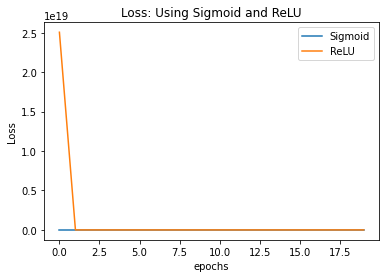

In [19]:
import matplotlib.pyplot as plt
plt.plot(loss_sigmoid, label='Sigmoid')
plt.plot(loss_relu, label='ReLU')
plt.title('Loss: Using Sigmoid and ReLU')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

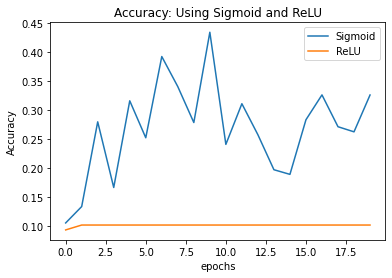

In [20]:
plt.plot(accuracy_sigmoid, label='Sigmoid')
plt.plot(accuracy_relu, label='ReLU')
plt.title('Accuracy: Using Sigmoid and ReLU')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Question 10

In [23]:
from vugrad.core import Module, TensorNode

from vugrad.ops import *
from vugrad.functions import *

class custom_Linear(Module):
    """
    A linear operation. Applies a matrix transformation and a vector translation.
    """

    def __init__(self, input_size, output_size):
        super().__init__()

        # weights of the matrix transformation
        w = np.random.randn(output_size,input_size)*np.sqrt(2/input_size) # He initialization
        self.w = TensorNode(w)

        # weights of the bias (the translation)
        b = np.zeros((1, output_size))
        self.b = TensorNode(b)
        # -- We initialize the biases to zero for simplicity. This is a common approach, but with ReLU units it's
        #    sometimes best to add a little noise to avoid dead neurons.

    def forward(self, input):

        outsize, insize = self.w.size()
        n, f = input.size()

        assert f == insize, f'Number of features in input ({f}) does not match input dimension ({insize}).'
        assert len(input.size()) == 2

        # Multiply all input vectors by the weight matrix.
        x = BatchMM.do_forward(self.w, input)

        assert x.size() == (n, outsize)

        exb = Expand.do_forward(self.b, dim=0, repeats=n)
        # -- We are broadcasting the (1, outsize) vector b over the (n, outsize) matrix x. Numpy normally does this
        #    automatically, if we just do `x + self.b`, but we wouldn't get a gradient over that operation. Expand
        #    is a minimal broadcasting op that is sufficient for our purposes.
        # -- In pytorch, full-featured broadcasting is implemented so there you would actually be able to do `x + self.b`.

        assert x.size() == exb.size()

        return x + exb

    def parameters(self):
        return [self.w, self.b]

In [25]:
accuracy_list = []
loss_list = []

# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=6):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = custom_Linear(input_size, hidden_size)
        self.layer2 = custom_Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = vg.sigmoid(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

## Instantiate the model
mlp = MLP(input_size=num_features, output_size=num_classes)

n, m = xtrain.shape
b = batch_size

print('\n## Starting training')
for epoch in range(epochs):

    print(f'epoch {epoch:03}')

    ## Compute validation accuracy
    o = mlp(vg.TensorNode(xval))
    oval = o.value

    predictions = np.argmax(oval, axis=1)
    num_correct = (predictions == yval).sum()
    acc = num_correct / yval.shape[0]

    o.clear() # gc the computation graph
    print(f'       accuracy: {acc:.4}')
    
    accuracy_list.append(acc)

    cl = 0.0 # running sum of the training loss

    # We loop over the data in batches of size `b`
    for fr in range(0, n, b):

        # The end index of the batch
        to = min(fr + b, n)

        # Slice out the batch and its corresponding target values
        batch, targets = xtrain[fr:to, :], ytrain[fr:to]

        # Wrap the inputs in a Node
        batch = vg.TensorNode(value=batch)

        outputs = mlp(batch)
        loss = vg.logceloss(outputs, targets)
        # -- The computation graph is now complete. It consists of the MLP, together with the computation of
        #    the scalar loss.
        # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
        #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
        #    and clearing the graph.
        # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

        cl += loss.value
        # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
        #    a running sum using the TensorNode?

        # Start the backpropagation
        loss.backward()

        # pply gradient descent
        for parm in mlp.parameters():
            parm.value -= lr * parm.grad
            # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
            #    part, we are not building up a computation graph.

        # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
        #    complexoptimizers than plain graident descent.

        # Finally, we need to reset the gradients to zero ...
        loss.zero_grad()
        # ... and delete the parts of the computation graph we don't need to remember.
        loss.clear()

    print(f'   running loss: {cl/n:.4}')
    loss_list.append(cl)


## Starting training
epoch 000


D:\Downloads\vugrad-main\vugrad-main\vugrad\ops.py:181: RuntimeWarning: overflow encountered in exp
  sigx =  1 / (1 + np.exp(-input))


       accuracy: 0.0816
   running loss: 218.8
epoch 001
       accuracy: 0.1086
   running loss: 186.7
epoch 002
       accuracy: 0.1982
   running loss: 180.2
epoch 003
       accuracy: 0.3122
   running loss: 133.2
epoch 004
       accuracy: 0.2998
   running loss: 132.8
epoch 005
       accuracy: 0.4304
   running loss: 113.9
epoch 006
       accuracy: 0.394
   running loss: 121.4
epoch 007
       accuracy: 0.3326
   running loss: 138.9
epoch 008
       accuracy: 0.459
   running loss: 123.4
epoch 009
       accuracy: 0.3822
   running loss: 128.9
epoch 010
       accuracy: 0.2556
   running loss: 151.3
epoch 011
       accuracy: 0.2554
   running loss: 152.3
epoch 012
       accuracy: 0.2672
   running loss: 127.9
epoch 013
       accuracy: 0.347
   running loss: 120.4
epoch 014
       accuracy: 0.4006
   running loss: 152.3
epoch 015
       accuracy: 0.2238
   running loss: 146.0
epoch 016
       accuracy: 0.3656
   running loss: 161.1
epoch 017
       accuracy: 0.2124
   running

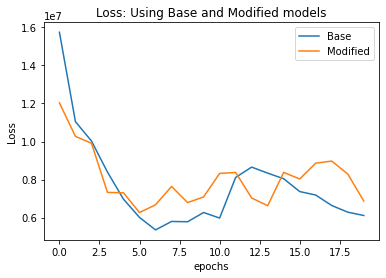

In [27]:
plt.plot(loss_sigmoid, label='Base')
plt.plot(loss_list, label='Modified')
plt.title('Loss: Using Base and Modified models')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

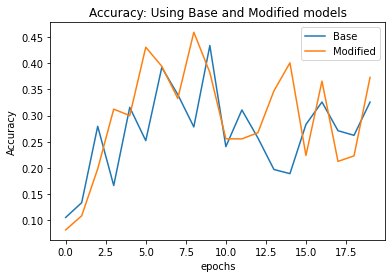

In [28]:
plt.plot(accuracy_sigmoid, label='Base')
plt.plot(accuracy_list, label='Modified')
plt.title('Accuracy: Using Base and Modified models')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
accuracy_list[-1], loss_list[-1]

(0.3728, 6873601.304278909)